In [2]:

import networkx as nx
import pandas as pd
import community.community_louvain as community_louvain
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
from termcolor import cprint
# import markov_clustering as mc

import igraph as ig
import leidenalg as la
import time
import numpy as np
import itertools as it
import numpy as np
# from pulp import *
import seaborn as sns
from faker import Factory
fake = Factory.create()

In [3]:
import pandas as pd
import pandas_profiling as pp
aisles = pd.read_csv('data/instacart-market-basket-analysis/aisles.csv')
departments = pd.read_csv('data/instacart-market-basket-analysis/departments.csv')
orders = pd.read_csv('data/instacart-market-basket-analysis/orders.csv')
order_products_prior = pd.read_csv('data/instacart-market-basket-analysis/order_products__prior.csv')
order_products_train = pd.read_csv('data/instacart-market-basket-analysis/order_products__prior.csv')
products = pd.read_csv('data/instacart-market-basket-analysis/products.csv')


In [4]:
order_products = order_products_prior.merge(products, on ='product_id', how='left')
order_products = order_products.merge(aisles, on ='aisle_id', how='left')
order_products = order_products.merge(departments, on ='department_id', how='left')
order_products = order_products.merge(orders, on='order_id', how='left')

In [20]:
final_data = pd.read_csv('/Users/koushik.saha/Downloads/Finaldata.csv', nrows=50000)
final_data = final_data.drop(columns=['Unnamed: 0'])
final_data.shape

(50000, 208)

In [3]:
final_data.head()

,user_id,product_id,total_product_orders_by_user,total_product_reorders_by_user,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,is_reorder_1,...,total_product_reordered_by_user,product_reorder_propotion_by_user,user_average_order_size,user_reorder_items_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1
0,1,196,10.0,9.0,1.400000,18.40,10.0,1.0,1.0,1.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
1,1,10258,9.0,8.0,3.333333,19.56,10.0,1.0,1.0,1.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
2,1,10326,1.0,0.0,5.000000,28.00,5.0,0.0,0.0,0.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
3,1,12427,10.0,9.0,3.300000,18.40,10.0,1.0,1.0,1.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
4,1,13032,3.0,2.0,6.333333,21.67,10.0,1.0,0.0,0.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667


In [83]:
final_data.head()
final_data['order_diff'] = final_data['order_number'] - final_data['last_ordered_in']
final_data[['user_id','product_id','order_diff']].sort_values(by=['order_diff'], ascending=False).head()

,user_id,product_id,order_diff
12429,313,40268,99.0
30874,786,49075,99.0
12341,313,3142,99.0
12206,310,4210,99.0
12290,310,35199,99.0


In [84]:
final_data.dropna(subset=['user_id', 'product_id','order_diff'], how='any', inplace=True)

<h1>Weighted Network: User vs order place difference in days</h1>

In [85]:
user_product_order_diff = final_data[['user_id','product_id','order_diff']].itertuples(name=None, index=False)

In [86]:
user_product_order_diff = list(user_product_order_diff)

<h2>Graph Creation and Cluster character analysis: Louvain</h2>

In [87]:
g1 = nx.Graph()
user_vertex = final_data['user_id'].unique().tolist()
aisle_vertex = final_data['product_id'].unique().tolist()
for each_user_id in user_vertex:
    g1.add_node(each_user_id, type='user_id')

for dept_id in aisle_vertex:
    g1.add_node(dept_id, type='product_id')

g1.add_weighted_edges_from(user_product_order_diff)

In [9]:

partition = community_louvain.best_partition(g1, random_state=42, resolution=1.0)
nodes_cluster_wise = []
for com in set(partition.values()):
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    nodes_cluster_wise = nodes_cluster_wise + [list_nodes]
community_num_group = len(nodes_cluster_wise)

In [10]:
print(community_num_group, community_louvain.modularity(partition,g1))

35 0.48991971470217477


In [11]:
cluster_analysis = []
for i in range(0,len(nodes_cluster_wise)):
  for cluster_nodes in nodes_cluster_wise[i]:
    node_type = g1.nodes[cluster_nodes]['type']
    row = {'node': cluster_nodes, 'type':node_type, 'cluster_id':i}
    cluster_analysis.append(row)

cluster_analysis = pd.DataFrame.from_records(cluster_analysis)
cluster_analysis.head()

,node,type,cluster_id
0,1,product_id,0
1,123,product_id,0
2,140,user_id,0
3,214,user_id,0
4,309,user_id,0


In [12]:
all_graph_edges = list(g1.edges())

In [15]:


import itertools as it
import numpy as np
all_communities_mean_order_placed_diff_in_days = []
for i in range(0,len(nodes_cluster_wise)):
    dummy = cluster_analysis[cluster_analysis['cluster_id']==i]
    weight_list = []
    node_list = dummy['node'].tolist()
    all_combinations = it.combinations(node_list,2)
    all_combinations = list(all_combinations)
    for edge in all_combinations:
        if edge in all_graph_edges:
            weight = g1.get_edge_data(*edge)['weight']
            weight_list.append(weight)
    
    print(f"cluster id {i} cluster mean {np.mean(weight_list)}")
    cluster_meta_info = {'cluster_id':i,'cluster_mean':np.mean(weight_list)}
    all_communities_mean_order_placed_diff_in_days.append(cluster_meta_info)
            

cluster id 0 cluster mean 22.09880239520958
cluster id 1 cluster mean 24.36541889483066
cluster id 2 cluster mean 22.007462686567163
cluster id 3 cluster mean 24.453924914675767
cluster id 4 cluster mean 15.285067873303168
cluster id 5 cluster mean 15.447154471544716
cluster id 6 cluster mean 28.023076923076925
cluster id 7 cluster mean 20.924335378323107
cluster id 8 cluster mean 14.79421768707483
cluster id 9 cluster mean 13.883116883116884
cluster id 10 cluster mean 22.720405862457724
cluster id 11 cluster mean 21.97459584295612
cluster id 12 cluster mean 9.310096153846153
cluster id 13 cluster mean 36.423529411764704
cluster id 14 cluster mean 17.74585635359116
cluster id 15 cluster mean 17.16121758737317
cluster id 16 cluster mean 13.39655172413793


KeyboardInterrupt: 

In [27]:
all_communities_mean_order_placed_diff_in_days = pd.DataFrame.from_records(all_communities_mean_order_placed_diff_in_days)
all_communities_mean_order_placed_diff_in_days.head()

,cluster_id,cluster_mean
0,0,22.098802
1,1,24.365419
2,2,22.007463
3,3,24.453925
4,4,15.285068


In [53]:
all_communities_mean_order_placed_diff_in_days['product_count']= None
all_communities_mean_order_placed_diff_in_days['user_count']= None
for cluster_id in all_communities_mean_order_placed_diff_in_days['cluster_id'].tolist():
    # print(f"cluster id {cluster_id}")
    user_prod_stat = cluster_analysis[cluster_analysis['cluster_id']==cluster_id]['type'].value_counts()
    product_count = None
    user_count = None
    try:
        product_count = user_prod_stat['product_id']
        user_count = user_prod_stat['user_id']
    except Exception as e:
        pass
    all_communities_mean_order_placed_diff_in_days.loc[all_communities_mean_order_placed_diff_in_days['cluster_id']==cluster_id,'product_count'] = product_count
    all_communities_mean_order_placed_diff_in_days.loc[all_communities_mean_order_placed_diff_in_days['cluster_id']==cluster_id,'user_count'] = user_count
    

In [54]:
from IPython.display import HTML
HTML(pd.DataFrame.from_records(all_communities_mean_order_placed_diff_in_days).to_html(index=False))

cluster_id,cluster_mean,product_count,user_count
0,22.098802,284,10
1,24.365419,422,16
2,22.007463,199,19
3,24.453925,261,7
4,15.285068,676,46
5,15.447154,413,18
6,28.023077,123,5
7,20.924335,361,24
8,14.794218,484,17
9,13.883117,77,1


In [60]:
cluster_analysis.groupby(by=['cluster_id',
                            'type']).size().to_frame('vertex_count')

vertex_count
cluster_id type                    
0          product_id           284
           user_id               10
1          product_id           422
           user_id               16
2          product_id           199
...                             ...
32         user_id               11
33         product_id           284
           user_id                9
34         product_id           238
           user_id               10

[70 rows x 1 columns]

<h2>Community Detection: Louvian</h2>

In [ ]:
def simple_Louvain(G, random_state=42, resolution=1.0,weight=None):
    if weight is None:
      partition = community_louvain.best_partition(G, random_state=random_state, resolution=resolution)
    else:
      partition = community_louvain.best_partition(G, random_state=random_state, resolution=resolution, weight=weight)
    modularity = community_louvain.modularity(partition, G)
    pos = graphviz_layout(G)
    max_k_w = []
    for com in set(partition.values()):
        list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
        max_k_w = max_k_w + [list_nodes]

    
    node_mapping = {}
    map_v = 0
    for node in G.nodes():
        node_mapping[node] = map_v
        map_v += 1

    community_num_group = len(max_k_w)
    color_list_community = [[] for i in range(len(G.nodes()))]
    
    # color
    for i in G.nodes():
        for j in range(community_num_group):
            if i in max_k_w[j]:
                color_list_community[node_mapping[i]] = j
    
    return G, pos, color_list_community, community_num_group, max_k_w, modularity, partition

In [ ]:
g1, pos, color_list_community, community_num_group, max_k_w, modularity, partition = simple_Louvain(g1)

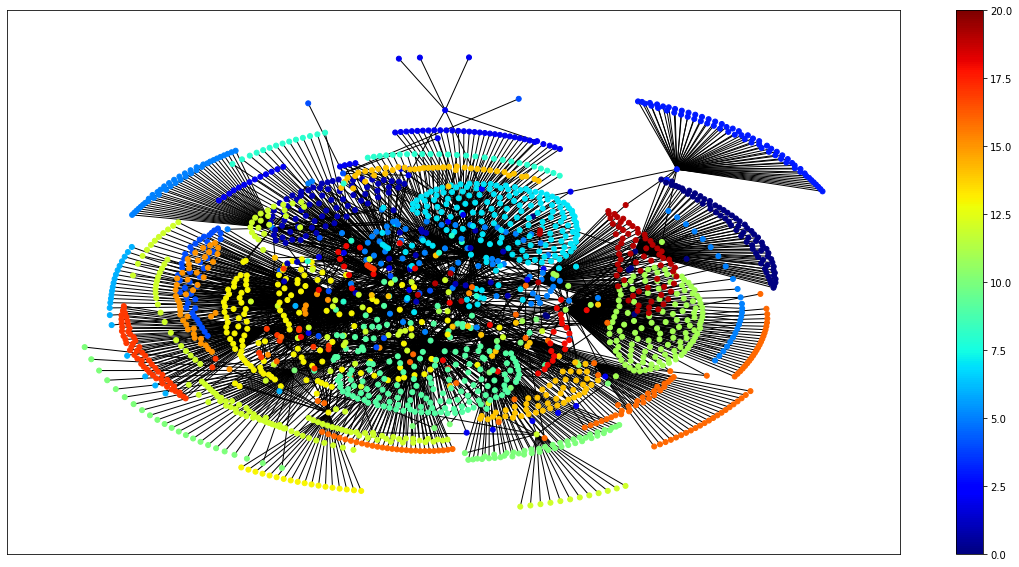

In [ ]:
edges = g1.edges()
Feature_color_sub = color_list_community
node_size = 25

fig = plt.figure(figsize=(20, 10))
im = nx.draw_networkx_nodes(g1, pos, node_size=node_size, node_color=Feature_color_sub, cmap='jet', vmin=0, vmax=community_num_group)
nx.draw_networkx_edges(g1, pos)
# nx.draw_networkx_labels(G, pos, font_size=12, font_color="black")
plt.xticks([])
plt.yticks([])
plt.colorbar(im)
plt.show(block=False)

In [ ]:

cprint(f"modularity {community_louvain.modularity(louvain_partition,g1)}", 'blue', attrs=['bold'])
nodes = list(louvain_partition.keys())
community_num = list(louvain_partition.values())
community_info = pd.DataFrame({'nodes':nodes,'community_num':community_num})
cprint(f"unique communities: {community_info['community_num'].unique()} community count {community_info['community_num'].nunique()}", "blue", attrs=['bold'])

modularity 0.6553418448961866
unique communities: [ 0  1  2  3  4  5  6  7 30  9 10 11 12 31 14 15 16 17 18  8 21 22 23 24
 25 26 27 28 29 32 33 34 35 19 20 13] community count 36


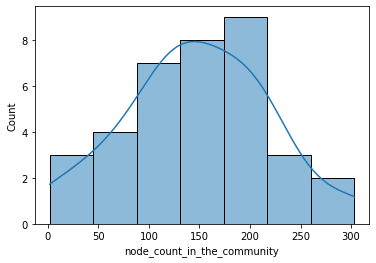

In [ ]:
community_meta = pd.DataFrame({'nodes':nodes,'community_num': community_num})
community_meta = community_meta['community_num'].value_counts().sort_values(ascending=False).to_frame('node_count_in_the_community').reset_index().rename(columns={'index':'community_id'})
user_product_order_placed_before_days_histogram = sns.histplot(data = community_meta,x='node_count_in_the_community', kde=True)
user_product_order_placed_before_days_histogram.figure.savefig("user_product_order_placed_before_days_histogram.png")

<h2>Community Detection: Leiden</h2>

In [ ]:
# leiden_partition = la.find_partition(ig.Graph.from_networkx(g1), la.ModularityVertexPartition, seed=42, n_iterations=20, weights='weight')

In [88]:
leiden_partition = la.find_partition(ig.Graph.from_networkx(g1), la.RBConfigurationVertexPartition, seed=42, n_iterations=20, weights='weight', resolution_parameter=0.4)

In [89]:
cprint(leiden_partition.summary() + " with modularity: " + str(round(leiden_partition.q,4)),'blue', attrs=['bold'])

Clustering with 13786 elements and 12 clusters with modularity: 0.304


In [91]:
total_community_no = len(set(leiden_partition.membership))

<h2>Leiden Cluster Insights</h2>

In [96]:
import numpy as np

leiden_cluster_meta_info = []
for i in range(0, total_community_no):
    edge_weights = [x[2]['weight'] for x in list(leiden_partition.subgraph(i).to_networkx().edges(data=True))]
    row = {'cluster_id':i,
        'order_place_diff_in_days': np.mean(edge_weights)}
    leiden_cluster_meta_info.append(row)
    
leiden_cluster_meta_info = pd.DataFrame.from_records(leiden_cluster_meta_info)
leiden_cluster_meta_info = leiden_cluster_meta_info.sort_values(by=['order_place_diff_in_days'], ascending=False)

In [97]:
leiden_cluster_meta_info.head(n=15)

,cluster_id,order_place_diff_in_days
3,3,31.635514
4,4,14.547945
7,7,13.473684
0,0,11.622263
5,5,11.189189
1,1,9.555511
2,2,8.180652
6,6,6.692308
10,10,6.000000
8,8,2.666667


In [99]:
from collections import Counter
import numpy as np
leiden_cluster_meta_info = []
for i in range(0, total_community_no):
    node_info = Counter([x[1]['type'] for x in list(leiden_partition.subgraph(i).to_networkx().nodes(data=True))])
    node_info = dict(node_info)
    node_info['cluster_id'] = i
    leiden_cluster_meta_info.append(node_info)

In [102]:
leiden_cluster_meta_info = pd.DataFrame.from_records(leiden_cluster_meta_info)
leiden_cluster_meta_info

,user_id,product_id,cluster_id
0,363,7122,0
1,162,5433,1
2,77,348,2
3,1,107,3
4,2,72,4
5,1,37,5
6,1,26,6
7,1,19,7
8,1,6,8
9,1,2,9


In [ ]:
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, NodesAndLinkedEdges, LabelSet, BoxZoomTool
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.palettes import Blues256, Reds8, Purples8, Oranges8, Viridis8, Spectral8, Viridis256, Oranges256, Blues8
from bokeh.transform import linear_cmap

In [ ]:
total_community_no = len(set(leiden_partition.membership))
color_list=[]
for i in range(0,total_community_no+1):
    color_list.append(fake.hex_color())

In [ ]:
modularity_class = {}
modularity_color = {}

for i in range(0, total_community_no):
    sub_graphs = leiden_partition.subgraphs()[i].to_networkx().nodes(data=True)
    sub_graphs = list(sub_graphs)
    node_list = [x[1]['_nx_name'] for x in sub_graphs]
    for node in node_list:
        modularity_class[node] = i
        modularity_color[node] = color_list[i]

In [ ]:
# Add modularity class and color as attributes from the network above
nx.set_node_attributes(g1, modularity_class, 'community_id')
nx.set_node_attributes(g1, modularity_color, 'community_color')

In [ ]:
edge_highlight_color='yellow'
node_highlight_color = 'skyblue'
#Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed

#Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed
# size_by_this_attribute = 'degree'
size_by_this_attribute = 15
color_by_this_attribute = 'community_color'

#Pick a color palette — Blues8, Reds8, Purples8, Oranges8, Viridis8
color_palette = Blues8
#Choose a title!
title = 'User vs Product Order difference in days'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [
       ("Character", "@index"),
        ("Degree", "@degree"),
         ("Community id", "@community_id"),
        ("Community Color", "$color[swatch]:community_color"),
]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
            tools="pan,wheel_zoom,save,reset,tap", active_scroll='wheel_zoom',
            x_range=Range1d(-20.1, 20.1), y_range=Range1d(-20.1, 20.1), title=title, plot_width=1400, plot_height=900)

#Create a network graph object
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
network_graph = from_networkx(g1, nx.spring_layout, scale=10, center=(0, 0))


#Set node sizes and colors according to node degree (color as category from attribute)
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=color_by_this_attribute)


#Set node highlight colors
network_graph.node_renderer.hover_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)
network_graph.node_renderer.selection_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Set edge highlight colors
network_graph.edge_renderer.selection_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)
network_graph.edge_renderer.hover_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)

#Highlight nodes and edges
network_graph.selection_policy = NodesAndLinkedEdges()
network_graph.inspection_policy = NodesAndLinkedEdges()
plot.add_tools(BoxZoomTool())
plot.renderers.append(network_graph)

#Add Labels
# x, y = zip(*network_graph.layout_provider.graph_layout.values())
# node_labels = list(g2.nodes())
# source = ColumnDataSource({'x': x, 'y': y, 'name': [node_labels[i] for i in range(len(x))]})
# labels = LabelSet(x='x', y='y', text='name', source=source, background_fill_color='white', text_font_size='10px', background_fill_alpha=.7)
# plot.renderers.append(labels)

In [ ]:
output_notebook()

In [ ]:
show(plot, notebook_handle=True)

<h1>Weighted Network: Days since prior order</h1>

In [21]:
final_data['order_number'] = final_data['order_number'].astype(int)
user_product_days_since_prior_order = final_data[['user_id','order_number','product_reorder_propotion_by_user']].itertuples(name=None, index=False)

In [22]:
user_product_days_since_prior_order = list(user_product_days_since_prior_order)

<h2>community insights: louvain</h2>

In [24]:
g2=nx.Graph()

In [25]:
user_vertex = final_data['user_id'].unique().tolist()
order_vertex = final_data['order_number'].unique().tolist()
for each_user_id in user_vertex:
    g2.add_node(each_user_id, type='user_id')

for dept_id in order_vertex:
    g2.add_node(dept_id, type='order_number')

g2.add_weighted_edges_from(user_product_days_since_prior_order)

In [14]:
partition = community_louvain.best_partition(g2, random_state=42, resolution=1.0)
nodes_cluster_wise = []
for com in set(partition.values()):
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    nodes_cluster_wise = nodes_cluster_wise + [list_nodes]
community_num_group = len(nodes_cluster_wise)

In [81]:
print(community_num_group, community_louvain.modularity(partition,g2))

57 0.9508482103719732


In [113]:
cluster_analysis = []
for i in range(0,community_num_group):
  for cluster_nodes in nodes_cluster_wise[i]:
    node_type = g2.nodes[cluster_nodes]['type']
    row = {'node': cluster_nodes, 'type':node_type, 'cluster_id':i}
    cluster_analysis.append(row)

cluster_analysis = pd.DataFrame.from_records(cluster_analysis)
cluster_analysis.head()

,node,type,cluster_id
0,1,user_id,0
1,48,order_number,0
2,59,order_number,0
3,62,order_number,0
4,64,order_number,0


In [63]:
cluster_analysis.groupby(by=['cluster_id','type']).size().to_frame('count').reset_index().head(n=15)

,cluster_id,type,count
0,0,order_number,5
1,0,user_id,35
2,1,order_number,1
3,1,user_id,14
4,2,order_number,1
5,2,user_id,75
6,3,order_number,2
7,3,user_id,48
8,4,order_number,1
9,4,user_id,1


In [64]:
all_graph_edges = list(g2.edges())

In [92]:
import itertools as it
import numpy as np
all_communities_mean_order_placed_diff_in_days = []
cluster_wise_edges = []
for i in range(0, community_num_group):
    dummy = cluster_analysis[cluster_analysis['cluster_id']==i]
    weight_list = []
    edge_list = dict()
    node_list = dummy['node'].tolist()
    all_combinations = it.combinations(node_list,2)
    all_combinations = list(all_combinations)
    for edge in all_combinations:
        if edge in all_graph_edges:
            weight = g2.get_edge_data(*edge)['weight']
            if len(edge_list.keys())==0:
                edge_list[i] = [edge]
            else:
                edge_list[i].append(edge)
            weight_list.append(weight)
    cluster_wise_edges.append(edge_list)
    
    # print(f"cluster id {i} cluster mean {np.mean(weight_list)}")
    if len(weight_list) > 0:
        try:
            cluster_meta_info = {'cluster_id':i,'cluster_mean':np.mean(weight_list)}
            all_communities_mean_order_placed_diff_in_days.append(cluster_meta_info)
        except Exception as e:
            pass

In [128]:
all_communities_mean_order_placed_diff_in_days = pd.DataFrame.from_records(all_communities_mean_order_placed_diff_in_days)
all_communities_mean_order_placed_diff_in_days = all_communities_mean_order_placed_diff_in_days.sort_values(by=['cluster_mean'], ascending=False)
all_communities_mean_order_placed_diff_in_days.head(n=15)

,cluster_id,cluster_mean
32,39,0.904899
36,47,0.898187
24,28,0.813617
7,7,0.809003
10,10,0.790262
20,24,0.764096
18,21,0.759382
44,55,0.735882
23,27,0.730385
29,35,0.726832


<h2>Community Detection: Louvain</h2>

In [ ]:
g2, pos, color_list_community, community_num_group, max_k_w, modularity, partition = simple_Louvain(g2)

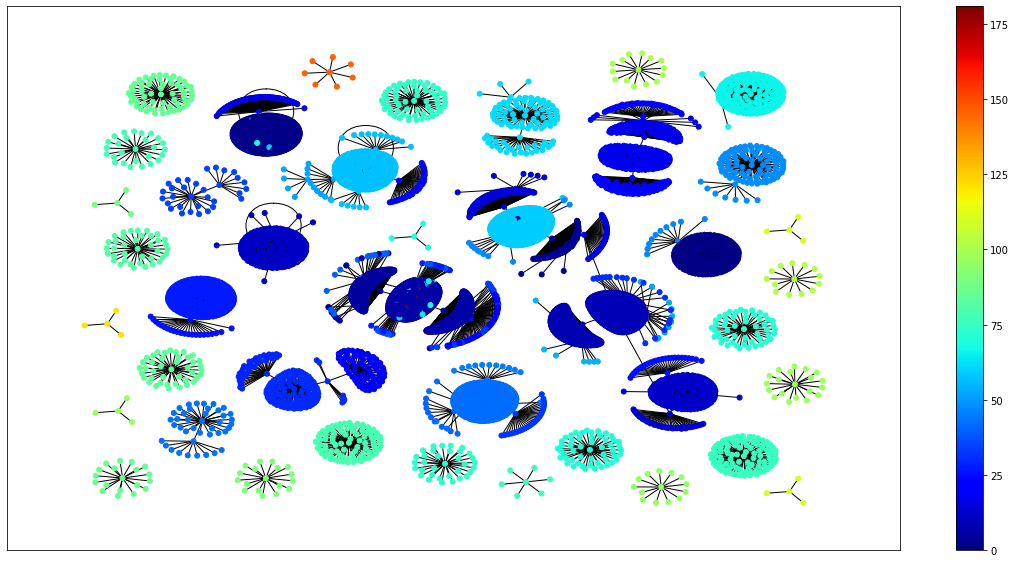

In [ ]:
edges = g2.edges()
Feature_color_sub = color_list_community
node_size = 25

fig = plt.figure(figsize=(20, 10))
im = nx.draw_networkx_nodes(g2, pos, node_size=node_size, node_color=Feature_color_sub, cmap='jet', vmin=0, vmax=community_num_group)
nx.draw_networkx_edges(g2, pos)
# nx.draw_networkx_labels(G, pos, font_size=12, font_color="black")
plt.xticks([])
plt.yticks([])
plt.colorbar(im)
plt.show(block=False)

In [ ]:
cprint(f"modularity {community_louvain.modularity(partition,g2)}", 'blue', attrs=['bold'])
nodes = list(partition.keys())
community_num = list(partition.values())
community_info = pd.DataFrame({'nodes':nodes,'community_num':community_num})
cprint(f"unique communities: {community_info['community_num'].unique()} community count {community_info['community_num'].nunique()}", "blue", attrs=['bold'])

modularity 0.965665477387601
unique communities: [ 42   1   2  59   4   5   6   7   8   9  57  11  12  13  14  15  16  17
  18  19  30  21  22  23  24  25  26  27  28  29  31  32  33  34  62  38
  39  41  43  45  46  47  48  52  53  54  55  66  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147
 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165
 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180   0   3  10
  20  35  36  37  40  44  49  50  51  56  58  60  61  63  64  65  67  68
  69] community count 181


<h2>Community Detection: Leiden</h2>

In [ ]:
leiden_partition = la.find_partition(ig.Graph.from_networkx(g2), la.RBConfigurationVertexPartition, seed=42, weights='weight',  n_iterations=20, resolution_parameter=0)

In [ ]:
cprint(leiden_partition.summary() + " with modularity: " + str(round(leiden_partition.q,4)),'blue', attrs=['bold'])

Clustering with 856 elements and 44 clusters with modularity: 0.8418


In [57]:
total_community_no = len(set(leiden_partition.membership))
color_list = []
for i in range(0,total_community_no+1):
    color_list.append(fake.hex_color())

<h2>Community Insights: Leiden<h2>

In [ ]:

import numpy as np
leiden_cluster_meta_info = []
for i in range(0, total_community_no):
    edge_weights = [x[2]['weight'] for x in list(leiden_partition.subgraph(i).to_networkx().edges(data=True))]
    row = {'cluster_id':i,
           're-order proportion': np.mean(edge_weights)}
    leiden_cluster_meta_info.append(row)
    
leiden_cluster_meta_info = pd.DataFrame.from_records(leiden_cluster_meta_info)
leiden_cluster_meta_info = leiden_cluster_meta_info.sort_values(by=['re-order proportion'], ascending=False)

In [66]:
leiden_cluster_meta_info.head(n=15)

,cluster_id,re-order proportion
27,27,0.904899
29,29,0.898187
17,17,0.813617
16,16,0.809003
25,25,0.790262
23,23,0.764096
22,22,0.759382
30,30,0.735882
19,19,0.726832
24,24,0.661730


In [75]:
from collections import Counter
import numpy as np
leiden_cluster_meta_info = []
for i in range(0, total_community_no):
    node_info = Counter([x[1]['type'] for x in list(leiden_partition.subgraph(i).to_networkx().nodes(data=True))])
    node_info = dict(node_info)
    node_info['cluster_id'] = i
    leiden_cluster_meta_info.append(node_info)

In [101]:
leiden_cluster_meta_info  = pd.DataFrame(leiden_cluster_meta_info)
leiden_cluster_meta_info.head()

,user_id,product_id,cluster_id
0,363,7122,0
1,162,5433,1
2,77,348,2
3,1,107,3
4,2,72,4


In [ ]:
modularity_class = {}
modularity_color = {}

for i in range(0, total_community_no):
    sub_graphs = leiden_partition.subgraphs()[i].to_networkx().nodes(data=True)
    sub_graphs = list(sub_graphs)
    node_list = [x[1]['_nx_name'] for x in sub_graphs]
    for node in node_list:
        modularity_class[node] = i
        modularity_color[node] = color_list[i]

In [ ]:
# Add modularity class and color as attributes from the network above
nx.set_node_attributes(g2, modularity_class, 'community_id')
nx.set_node_attributes(g2, modularity_color, 'community_color')

In [ ]:
edge_highlight_color='yellow'
node_highlight_color = 'skyblue'
#Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed

#Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed
# size_by_this_attribute = 'degree'
size_by_this_attribute = 15
color_by_this_attribute = 'community_color'

#Pick a color palette — Blues8, Reds8, Purples8, Oranges8, Viridis8
color_palette = Blues8
#Choose a title!
title = 'User vs Product Order difference in days'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [
       ("Character", "@index"),
        ("Degree", "@degree"),
         ("Community id", "@community_id"),
        ("Community Color", "$color[swatch]:community_color"),
]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
            tools="pan,wheel_zoom,save,reset,tap", active_scroll='wheel_zoom',
            x_range=Range1d(-20.1, 20.1), y_range=Range1d(-20.1, 20.1), title=title, plot_width=1400, plot_height=900)

#Create a network graph object
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
network_graph = from_networkx(g2, nx.spring_layout, scale=10, center=(0, 0))


#Set node sizes and colors according to node degree (color as category from attribute)
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=color_by_this_attribute)


#Set node highlight colors
network_graph.node_renderer.hover_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)
network_graph.node_renderer.selection_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Set edge highlight colors
network_graph.edge_renderer.selection_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)
network_graph.edge_renderer.hover_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)

#Highlight nodes and edges
network_graph.selection_policy = NodesAndLinkedEdges()
network_graph.inspection_policy = NodesAndLinkedEdges()
plot.add_tools(BoxZoomTool())
plot.renderers.append(network_graph)

#Add Labels
# x, y = zip(*network_graph.layout_provider.graph_layout.values())
# node_labels = list(g2.nodes())
# source = ColumnDataSource({'x': x, 'y': y, 'name': [node_labels[i] for i in range(len(x))]})
# labels = LabelSet(x='x', y='y', text='name', source=source, background_fill_color='white', text_font_size='10px', background_fill_alpha=.7)
# plot.renderers.append(labels)

In [ ]:
output_notebook()

In [ ]:
show(plot, notebook_handle=True)

# **`Weighted Network: User vs product brought from departments`**

In [5]:
order_products_v1 = order_products.sample(n=5000, replace=False, random_state=42) # random sampling to minimise the data set to run in the local

In [6]:
order_products.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


In [ ]:
unique_depts_per_user = order_products.groupby(by=['user_id'])['department_id'].unique().to_frame('dept_list').reset_index()

In [246]:
unique_depts_per_user['dept_list']

,user_id,dept_list
0,1,"[7, 19, 16, 4, 13, 14, 17]"
1,2,"[20, 19, 7, 4, 1, 16, 12, 13, 6, 14, 11, 3, 15]"
2,3,"[16, 4, 19, 17, 7, 9, 13, 1, 20]"
3,4,"[5, 7, 15, 3, 4, 1, 17, 19, 20]"
4,5,"[20, 16, 4, 6, 15, 9, 13, 19, 1]"
...,...,...
206204,206205,"[16, 4, 3, 7, 20, 12, 1, 18, 21]"
206205,206206,"[16, 1, 19, 3, 13, 4, 7, 15, 17, 12, 9, 6, 20,..."
206206,206207,"[16, 4, 7, 1, 12, 15, 19, 9, 13, 14, 20, 3, 6,..."
206207,206208,"[3, 4, 19, 16, 15, 13, 6, 14, 1, 9, 11, 20, 7,..."


In [8]:
cross_df = pd.crosstab(index=order_products_v1['user_id'], columns=order_products_v1['department_id'])
cross_df.head()

department_id,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
user_id,,,,,,,,,,,,,,,,,,,,,
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
58,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
140,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
154,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [9]:
norm_user_dept = cross_df.div(cross_df.sum(axis=1), axis=0)

In [10]:
norm_user_dept = norm_user_dept.reset_index()

In [ ]:
all_nodes_edges = []
for index,row in norm_user_dept.iterrows():
    user_id = row['user_id']
    row.drop(index=['user_id'], inplace=True)
    non_zero_relations = row[row > 0.0]
    nodes_edges = non_zero_relations.to_frame('weight').reset_index()
    nodes_edges['user_id']=int(user_id)
    nodes_edges = nodes_edges.rename(columns={'departent_id':'node1','user_id':'node2'})
    nodes_edges = nodes_edges[['node1','node2','weight']]
    nodes_edges['node1'] = nodes_edges['node1'].astype(str)
    nodes_edges['node2'] = nodes_edges['node2'].astype(str)
    relations = list(nodes_edges.itertuples(index=False, name=None))
    all_nodes_edges.append(relations)

relation_generator = it.chain.from_iterable(all_nodes_edges)
networkx_edges = []
for relation in relation_generator:
    networkx_edges.append(relation)

In [258]:
g2 = nx.Graph()

In [259]:
user_vertext = norm_user_dept['user_id'].unique().tolist()
for each_user_id in user_vertex:
    g2.add_node(each_user_id, type='user_id')

In [260]:
dept_info = order_products_v1['department_id'].unique().tolist()
for dept_id in dept_info:
    g2.add_node(dept_id, type='department_id')

In [261]:
g2.add_weighted_edges_from(networkx_edges)

In [266]:
partition = community_louvain.best_partition(g2, random_state=42, resolution=1, weight='weight')
nodes_cluster_wise = []
for com in set(partition.values()):
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    nodes_cluster_wise = nodes_cluster_wise + [list_nodes]
community_num_group = len(nodes_cluster_wise)

In [267]:
print(community_num_group, community_louvain.modularity(partition,g2))

843 0.20505133952887766


In [ ]:
cluster_analysis = []
for i in range(0,community_num_group):
    for cluster_nodes in nodes_cluster_wise[i]:
        node_type = g2.nodes[cluster_nodes]['type']
        row = {'node': cluster_nodes, 'type':node_type, 'cluster_id':i}
        cluster_analysis.append(row)

cluster_analysis = pd.DataFrame.from_records(cluster_analysis)
cluster_analysis.head()